In [1]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *

## Collecting & Preparing the data

### Setting up the configuration

In [2]:
# Se utiliza un rango de 20 años para la extraccion de datos económicos
timeframe = 365*20
today = datetime.today()
end = today.strftime("%Y-%m-%d")
start = (today - dt.timedelta(days=timeframe)).strftime("%Y-%m-%d")
periods = "W"

medidas = ["mean", "median", "mode", "Min", "Percentil_25", "Percentil_75","Max", "var", "std", "skew", "kurt"]

root_path = Path(r'C:\Users\Joan Oliver\BullGlobe\Investing_Scripts\Economic_Market_Forecasting\src')
config_paths = [
    "config\Market_Data_Config.csv",
    "config\Economic_Data_Config.csv",
    "config\Calc_Data_Config.csv"
]
market_config = root_path.joinpath(config_paths[0])
economic_config = root_path.joinpath(config_paths[1]).abspath()
calc_config = root_path.joinpath(config_paths[2]).abspath()


markets_used = ['SPY', 'GDX', 'BND']

target = "SP500"

# ML random seed
seed = 2

extract = True

cutoff_date = "2023-01-01"

### Loading and extracting the data

In [3]:
# Initialize the Economic Data Analyzer class
eda = EconomicDataAnalyzer()

In [4]:
# Load the Market Data
print("> Load the market data config")
market = eda.read_config(market_config)
market_dict = eda.convert_to_dictionary(markets_used=markets_used)
market_dict = market_dict['Market']
market_dict
# Load the economic data config
print("> Load the economic data config")
econ = eda.read_config(economic_config)
fred_series_dict = eda.convert_to_dictionary(markets_used=None)
fred_series_dict = fred_series_dict["Indicador"]
calc = eda.read_config(calc_config)
series_calc_dict = eda.convert_to_dictionary(markets_used=None)
series_calc_dict = series_calc_dict["Indicador"]
econ
# Setting up the indicator dictionaries
print("> Setting up the indicator dictionaries")
indicators = {}
for ind in list(econ["Tipo"].unique()):
    indicators[ind] = econ[econ["Tipo"] == ind]["Indicador"].to_list()
if extract == True:
    # Extracting the indicator data
    print("> Extracting the indicator data")
    indicators_df = eda.indicator_extraction(fred_series_dict, series_calc_dict, root_path=root_path)
    # Extracting the market data
    print("> Extracting the market data")
    stocks = list(market_dict.keys())
    market_df = eda.market_extraction(stocks, start, end, root_path=root_path)
else:
    print("No data extraction, reading data from data file")
    path = root_path.joinpath('data', 'raw', 'indicators_df.csv')
    indicators_df = pd.read_csv(path)
    path = root_path.joinpath('data', 'raw', 'market_df.csv')
    market_df = pd.read_csv(path)

> Load the market data config
> Load the economic data config
> Setting up the indicator dictionaries
> Extracting the indicator data
   -->Extracting 10-Year Treasury Yield...
   -->Extracting 2-Year Treasury Yield...
   -->Extracting Federal Funds Effective Rate...
   -->Extracting 1-Month Treasury Yield...
   -->Extracting 3-Month Treasury Yield...
   -->Extracting 5-Year Treasury Yield...
   -->Extracting 20-Year Treasury Yield...
   -->Extracting 30-Year Treasury Yield...
   -->Extracting 15-Year Mortgage Rate...
   -->Extracting 30-Year Mortgage Rate...
   -->Extracting Unemployment Rate...
   -->Extracting GDP...
   -->Extracting Real GDP...
   -->Extracting CPI...
   -->Extracting PPI...
   -->Extracting Consumer Confidence Index...
   -->Extracting Government Debt...
   -->Extracting Debt Service vs Disposable Income...
   -->Extracting US Dollar Index...
   -->Extracting Corporate Profits...
   -->Extracting EBIT...
   -->Extracting Retained Earnings...
   -->Extracting Build

### Cleaning the data

In [5]:
# Cleaning the indicator data
print("> Cleaning the indicator data")
df_indicators, df_indicators_cum, df_indicators_diff, df_indicators_rets, df_indicators_limpio = eda.limpiar_indicators(
    df_indicators=indicators_df, 
    indicator_dict=indicators, 
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=root_path)
# Cleaning the market data
print("> Cleaning market data")
df_market, df_markets_rets, df_markets_cum, df_markets_diff  = eda.limpiar_markets(
    markets_dict=market_dict,
    df_markets=market_df,
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=root_path)


> Cleaning the indicator data
> Cleaning market data


### Merge indicator and market data

In [6]:
list_market_dfs = [df_market,df_markets_rets,df_markets_cum,df_markets_diff]
list_indicators_dfs = [df_indicators_limpio,df_indicators_rets,df_indicators_cum,df_indicators_diff]

df_all_data, df_all_data_rets, df_all_data_cum, df_all_data_diff = eda.merge_data(list_market_dfs, list_indicators_dfs)

### Adding features

In [7]:
df_all_data["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)
# df_all_data["CAPE Ratio"].plot()
def trend_line(df, name, deg=2):
    coef = np.polyfit(range(0,len(df[name])), df[name], deg)
    x_trend = np.linspace(0,len(df[name]),len(df[name]))
    y_trend = np.polyval(coef, x_trend)
    df = pd.DataFrame(y_trend, index=df.index, columns=[name])
    return df 
# df_all_data = pd.DataFrame()
df_all_data["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
df_all_data["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)
# df_all_data = pd.DataFrame()
std = df_all_data["SP_GDP"].std()
df_all_data["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)

# df_all_data = df_all_data.copy()
# df_ts = df_all_data.loc[:,df_all_data.columns.str.contains(f"t-")]
# df_all_data.drop(df_ts.columns,axis=1,inplace=True)
for ma in df_all_data.columns:
    df_all_data[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
    df_all_data[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
    df_all_data[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]
    
    

In [13]:
# df_add_feat = df_all_data.loc[:,df_all_data.columns.str.contains("_")]
# for feat in df_add_feat.columns:
#     df_all_data_rets[feat] = df_add_feat[feat].pct_change().fillna(method="ffill").fillna(method="bfill")

In [14]:
# df_all_data, df_MKT_GDP = eda.mkt_gdp(df_all_data, "MKT_GDP", n_stds=2, deg=2)
# df_MKT_GDP.plot()
# df_MKT_GDP.plot()

### Creating lags in the data

In [9]:
list_data_dfs = [df_all_data,df_all_data_rets,df_all_data_cum,df_all_data_diff]

df_all_lag_data, df_all_lag_data_rets, df_all_lag_data_cum, df_all_lag_data_diff = eda.lag_data(list_data_dfs, target, n_lags=12)

In [12]:
df = eda.remove_outliers(df_all_lag_data_rets)
print(df.shape)
# df = pd.concat([df,df_MKT_GDP], axis=1).dropna()

(1032, 469)


## Data Preprocessing & Feature Engineering

In [15]:
econ_ml = Preprocessor()

### Indentifying the most important features

In [ ]:
print("> Performing feature importance analysis")
df_top_data, rf_feature_importance, rf_top_feature_importance, score = econ_ml.rf_feature_importance(target=target, df_data=df.loc[:cutoff_date], accepted_importance=0.95)

### Splitting the data

In [16]:
X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)

### Scaling the data

In [17]:
X_train_scale, X_test_scale = econ_ml.scaler(X_train=X_train, X_test=X_test)

In [18]:
from kerasbeats import prep_time_series, NBeatsModel

## Performing Machine Learning

In [19]:
def lstm_model(epochs,batch_size,validation_split):
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    lstm_model.add(LSTM(32))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return lstm_model

def gru_model(epochs,batch_size,validation_split):
    # gru model
    gru_model = Sequential()
    gru_model.add(GRU(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    gru_model.add(GRU(32))
    gru_model.add(Dense(units=1))
    gru_model.compile(optimizer='adam', loss='mse')
    gru_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return gru_model

def cnn_model(epochs,batch_size,validation_split):
    # cnn model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=1))
    cnn_model.compile(optimizer='adam', loss='mse')
    cnn_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return cnn_model
def n_beats():
    n_beats = NBeatsModel()

In [21]:
models = {
    "LSTM":lstm_model(epochs=15,batch_size=16,validation_split=0.2),
    "GRU":gru_model(epochs=15,batch_size=16,validation_split=0.2),
    "CNN":cnn_model(epochs=15,batch_size=16,validation_split=0.2)
}

Epoch 1/15
44/44 [==============================] - 14s 265ms/step - loss: 3.8364e-04 - val_loss: 1.6460e-04
Epoch 2/15
44/44 [==============================] - 11s 253ms/step - loss: 2.0004e-04 - val_loss: 1.4936e-04
Epoch 3/15
44/44 [==============================] - 11s 252ms/step - loss: 1.7763e-04 - val_loss: 1.6819e-04
Epoch 4/15
44/44 [==============================] - 11s 255ms/step - loss: 1.8390e-04 - val_loss: 1.7946e-04
Epoch 5/15
44/44 [==============================] - 11s 256ms/step - loss: 1.7229e-04 - val_loss: 1.4740e-04
Epoch 6/15
44/44 [==============================] - 11s 251ms/step - loss: 1.7220e-04 - val_loss: 1.5863e-04
Epoch 7/15
44/44 [==============================] - 11s 254ms/step - loss: 1.7684e-04 - val_loss: 1.6875e-04
Epoch 8/15
44/44 [==============================] - 11s 252ms/step - loss: 1.7457e-04 - val_loss: 1.4750e-04
Epoch 9/15
44/44 [==============================] - 11s 255ms/step - loss: 1.7405e-04 - val_loss: 1.8376e-04
Epoch 10/15
44/44 [

In [22]:
for name, model in models.items():
    print(f"Evaluate the model: {name}: {model.evaluate(X_test_scale, y_test)}")
    # model.evaluate(X_test_scale, y_test)

5/5 [==============================] - 1s 94ms/step - loss: 1.9910e-04
Evaluate the model: LSTM: 0.00019910314586013556
5/5 [==============================] - 1s 62ms/step - loss: 2.1803e-04
Evaluate the model: GRU: 0.00021802837727591395
5/5 [==============================] - 0s 4ms/step - loss: 0.0027
Evaluate the model: CNN: 0.0027189094107598066


Review of model: LSTM
5/5 [==============================] - 0s 86ms/step
Review of model: GRU
5/5 [==============================] - 0s 64ms/step
Review of model: CNN
5/5 [==============================] - 0s 6ms/step


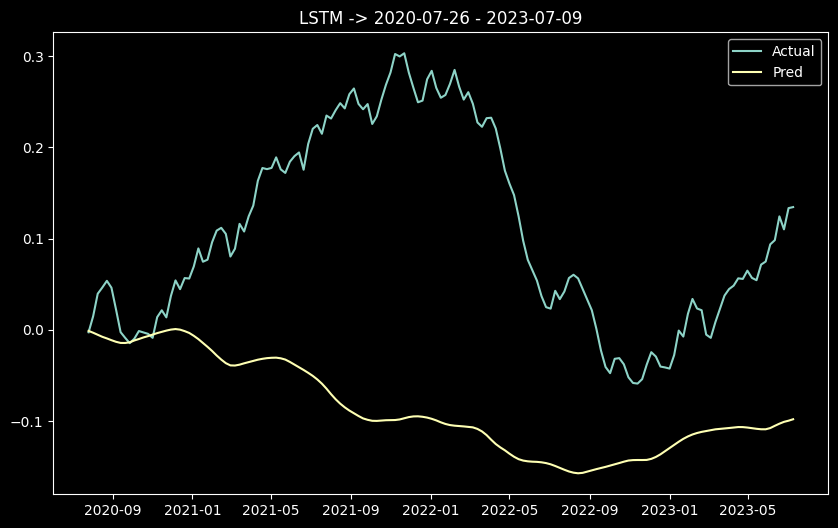

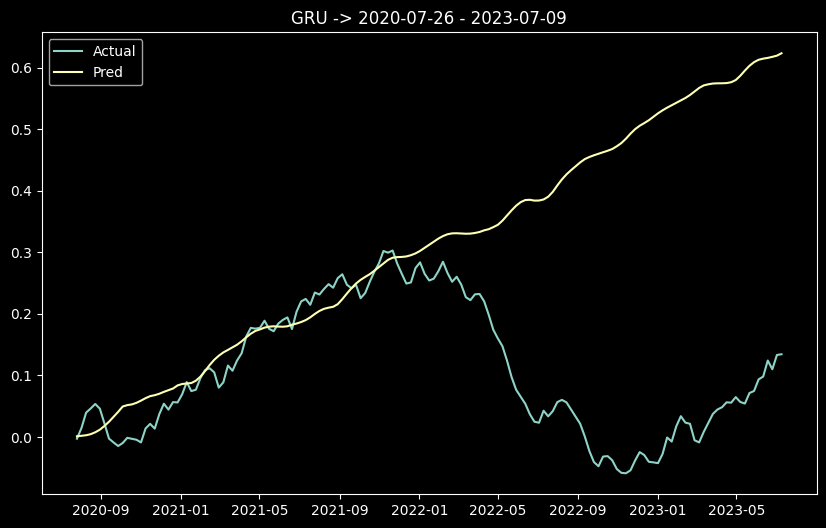

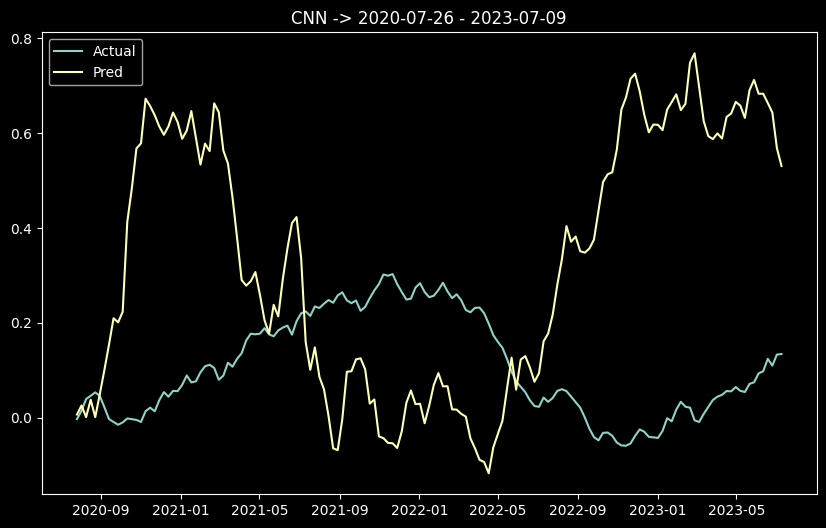

In [30]:
for name, model in models.items():
    print(f"Review of model: {name}")
    # if name != "CNN":
    try:
        df_history = pd.DataFrame({"Loss":model.history.history['loss'], "Val_Loss":model.history.history['val_loss']})
        df_history.plot(figsize=(10, 6), title=name)
    except:
        pass
    pred = model.predict(X_test_scale)
    predictions = pd.DataFrame(pred, index=y_test.index)
    predictions.index = pd.to_datetime(predictions.index)
    model.save(f'models\models\{name}_best_model_no_rets.h5')
    model.save_weights(f'models\weights\{name}_best_model_no_rets.h5') 
    # print(model.summary())
    plt.figure(figsize=(10, 6))
    plt.title(f"{name} -> {X_test.index[0]} - {X_test.index[-1]}")
    # plt.plot(df_all_lag_data["SP500"].pct_change())
    plt.plot(pd.to_datetime(y_test.index), y_test.cumsum(), label='Actual')
    plt.plot((predictions.cumsum()), label="Pred")
    plt.legend()